In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import regex
import re
import seaborn as sn
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from textblob import Word
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score,roc_curve,auc
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.metrics import classification_report
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import Doc2Vec,TaggedDocument
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import LabeledSentence
import multiprocessing
from sklearn import utils
plt.style.use('ggplot')
%matplotlib notebook

## Chargement des données et néttoyage:

In [2]:
import spacy
nlp = spacy.load('en')
def fonction_nettoyage_text(df):
    # supprission des ponctuations
    rm_ponct = str.maketrans('','',string.punctuation)
    df = df.apply(lambda x:x.translate(rm_ponct))
    # suppression les unicodes
    df = df.apply(lambda x:x.encode("ascii","ignore").decode("utf-8"))
                                                
    # suppression des URLs
    df = df.apply(lambda x:re.sub(r'http\S+',"",x))
    
    # suppression des stopwords
    stop_en = stopwords.words("english")
    df = df.apply(lambda x:" ".join(x.lower() for x in np.str(x).split() if x.lower() not in stop_en))
                                                  # Lemmatisation
    df = df.apply(lambda x:" ".join([ word.lemma_ for word in nlp(x) if word.lemma_!="-PRON-"]))              
    return(df)

## Split train-test validation:

In [3]:
dataset = pd.read_csv("data_set_version_final.csv")
dataset.resume=fonction_nettoyage_text(dataset.resume)

In [4]:
X_train,X_test,Y_train,y_test = train_test_split(dataset.resume,dataset.Labels,test_size=0.3,shuffle=True)
x_train,x_val,y_train,y_val = train_test_split(X_train,Y_train,test_size=0.3,shuffle=True)

## Transformation Doc2Vec:

## BDOW:
Nous allons utilisé le paramètre dm=0 pour préciser que l'on va utiliser le DBOW. Pour les autres paramètres, on va prendre les paramètres par défaut. 

In [5]:
from Doc2VecTransformer import EmbeddingDoc2Vec

In [6]:
docvecbd=EmbeddingDoc2Vec(dm=0)

In [7]:
docvecbd.fit(x_train,y_train)

100%|██████████| 92717/92717 [00:00<00:00, 3452597.19it/s]


In [12]:
y_train,X_embeded_train_D2v=docvecbd.transform(x_train,y_train)
y_val,X_embeded_val_D2v=docvecbd.transform(x_val,y_val)
y_test,X_embeded_test_D2v=docvecbd.transform(X_test,y_test)

## SVM:

/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number o


 C optimal = 0.13894954943731375


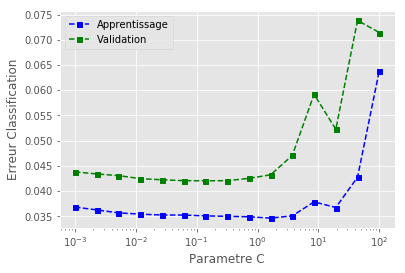

In [13]:
vectC = np.logspace(-3, 2, 15)
err_val = np.empty(vectC.shape[0])
err_app = np.empty(vectC.shape[0])
clf_svm=LinearSVC(C=1)

for ind_C, C in enumerate(vectC):
    clf_svm.C = C
    clf_svm.fit(X_embeded_train_D2v, y_train)
    # calcule erreur sur les donnees de validation et app
    err_val[ind_C] = 1 - accuracy_score(y_val, clf_svm.predict(X_embeded_val_D2v))
    err_app[ind_C] = 1 - accuracy_score(y_train, clf_svm.predict(X_embeded_train_D2v))
err_min_val, ind_min = err_val.min(), err_val.argmin()
Copt = vectC[ind_min]
print("\n C optimal = {}".format(Copt))
# Trace courbe erreur
plt.figure()
plt.semilogx(vectC, err_app, color="blue", linestyle="--", marker="s", markersize=5, label="Apprentissage")
plt.semilogx(vectC, err_val, color="green", linestyle="--", marker="s", markersize=5, label="Validation")
plt.xlabel("Parametre C")
plt.ylabel("Erreur Classification")
plt.legend(loc="best")
plt.show()

## Qualité du modèle:

In [14]:
from sklearn.metrics import recall_score,average_precision_score,f1_score
from sklearn.calibration import CalibratedClassifierCV

In [16]:
prediction=clf_svm.predict(X_embeded_test_D2v)
print(classification_report(y_test, prediction))

                   precision    recall  f1-score   support

Finance_actuariat       0.98      0.97      0.98      1531
       chirurgien       0.76      0.97      0.85      7997
     cryptography       0.98      0.96      0.97      3224
   data scientist       0.81      0.97      0.88      3427
          dentist       0.98      0.85      0.91      8388
        developer       1.00      0.50      0.67      2212
ditital_marketing       0.98      0.98      0.98      3573
 network_engineer       0.99      0.91      0.95      3744
            nurse       0.97      0.84      0.90     10851
       pharmacist       0.95      0.94      0.95      6254
          robotic       0.82      0.99      0.90      5566

        micro avg       0.90      0.90      0.90     56767
        macro avg       0.93      0.90      0.90     56767
     weighted avg       0.92      0.90      0.90     56767



In [17]:
print("recall:{}".format(recall_score(y_test, prediction,average='weighted')))
print("accuracy:{}".format(accuracy_score(y_test,prediction)))
print("F1-score:{}".format(f1_score(y_test,prediction,average='weighted')))

recall:0.9049095425158983
accuracy:0.9049095425158983
F1-score:0.9039058305131785


## Logisitic Regression:

In [20]:
rl=LogisticRegression(multi_class="auto",solver="lbfgs")

1it [00:05,  5.86s/it]/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
2it [00:14,  6.70s/it]/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
3it [00:23,  7.24s/it]/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
4it [00:31,  7.63s/it]/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
5it [00:39,  7.80s/it]/home/tantely/anaconda3/lib/python3.6/site-pac


 C optimal = 1.6


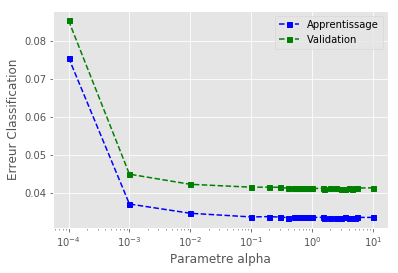

In [21]:
vectC = np.array([1e-4,1e-3,1e-2,1e-1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.5,1.6,2,2.5,3,3.5,4,4.5,5,5.5,10])
err_val = np.empty(vectC.shape[0])
err_app = np.empty(vectC.shape[0])
for ind_C, C in tqdm(enumerate(vectC)):
    rl.C=C
    temp=rl.fit(X_embeded_train_D2v, y_train)
    # calcule erreur sur les donnees de validation et app
    err_val[ind_C] = 1 - accuracy_score(y_val, rl.predict(X_embeded_val_D2v))
    err_app[ind_C] = 1 - accuracy_score(y_train, rl.predict(X_embeded_train_D2v))
err_min_val, ind_min = err_val.min(), err_val.argmin()
Copt = vectC[ind_min]
print("\n C optimal = {}".format(Copt))
# Trace courbe erreur
plt.figure()
plt.semilogx(vectC, err_app, color="blue", linestyle="--", marker="s", markersize=5, label="Apprentissage")
plt.semilogx(vectC, err_val, color="green", linestyle="--", marker="s", markersize=5, label="Validation")
plt.xlabel("Parametre alpha")
plt.ylabel("Erreur Classification")
plt.legend(loc="best")
plt.show()

In [22]:
rl.C=Copt
temp=rl.fit(X_embeded_train_D2v, y_train)
predRL=rl.predict(X_embeded_test_D2v)   
print("recall:{}".format(recall_score(y_test, predRL,average='weighted')))
print("accuracy:{}".format(accuracy_score(y_test,predRL)))
print("F1-score:{}".format(f1_score(y_test,predRL,average='weighted')))

/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


recall:0.9582151602163229
accuracy:0.9582151602163229
F1-score:0.9582215482665992


In [23]:
print(classification_report(y_test, predRL))

                   precision    recall  f1-score   support

Finance_actuariat       0.99      0.98      0.99      1531
       chirurgien       0.94      0.94      0.94      7997
     cryptography       0.98      0.99      0.98      3224
   data scientist       0.96      0.96      0.96      3427
          dentist       0.95      0.96      0.95      8388
        developer       0.97      0.95      0.96      2212
ditital_marketing       0.99      0.98      0.98      3573
 network_engineer       0.98      0.97      0.98      3744
            nurse       0.94      0.94      0.94     10851
       pharmacist       0.96      0.96      0.96      6254
          robotic       0.96      0.97      0.97      5566

        micro avg       0.96      0.96      0.96     56767
        macro avg       0.97      0.96      0.97     56767
     weighted avg       0.96      0.96      0.96     56767



## KNN:

In [24]:
knn=KNeighborsClassifier()

100%|██████████| 8/8 [2:14:14<00:00, 1140.50s/it]

With all being CV, best k is 3 and best perf is 0.9746080479150414


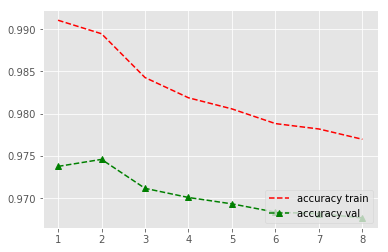

In [25]:
k_values = [2,3,5,6,7,8,9,10]
perf_train=[]
perf_val=[]
for k in tqdm(k_values):
    knn.n_neighbors=k
    knn.fit(X_embeded_train_D2v, y_train)
    y_pred_train = knn.predict(X_embeded_train_D2v)
    y_pred_val=knn.predict(X_embeded_val_D2v)
    scores_train = accuracy_score(y_train, y_pred_train)
    scores_val=accuracy_score(y_val,y_pred_val)
    perf_train.append(scores_train)
    perf_val.append(scores_val)
plt.figure()
plt.plot(range(1,len(perf_train)+1),perf_train,"--r",range(1,len(perf_val)+1),perf_val,"--g^")
plt.legend(['accuracy train', 'accuracy val'],loc="lower right")
print('With all being CV, best k is '    +repr(k_values[perf_val.index(max(perf_val))])+ ' and best perf is ' + repr(max(perf_val)))

In [26]:
knn.n_neighbors=k_values[perf_val.index(max(perf_val))]
knn.fit(X_embeded_train_D2v, y_train)
pred_knn = knn.predict(X_embeded_test_D2v)

In [27]:
print(classification_report(y_test, pred_knn))

                   precision    recall  f1-score   support

Finance_actuariat       0.99      0.99      0.99      1531
       chirurgien       0.95      0.97      0.96      7997
     cryptography       0.99      0.99      0.99      3224
   data scientist       0.97      0.98      0.97      3427
          dentist       0.97      0.97      0.97      8388
        developer       0.98      0.96      0.97      2212
ditital_marketing       0.99      0.99      0.99      3573
 network_engineer       0.99      0.99      0.99      3744
            nurse       0.97      0.96      0.96     10851
       pharmacist       0.98      0.97      0.98      6254
          robotic       0.99      0.99      0.99      5566

        micro avg       0.97      0.97      0.97     56767
        macro avg       0.98      0.98      0.98     56767
     weighted avg       0.97      0.97      0.97     56767



In [28]:
print("recall:{}".format(recall_score(y_test, pred_knn,average='weighted')))
print("accuracy:{}".format(accuracy_score(y_test,pred_knn)))
print("F1-score:{}".format(f1_score(y_test,pred_knn,average='weighted')))

recall:0.9737699719907693
accuracy:0.9737699719907693
F1-score:0.9737781363567246


### Naîve Baysian:

In [29]:
modelNB=MultinomialNB()

24it [00:08,  2.99it/s]



 C optimal = 4.5


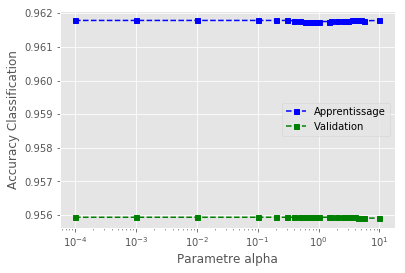

In [36]:
vectC = np.array([1e-4,1e-3,1e-2,1e-1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.5,1.6,2,2.5,3,3.5,4,4.5,5,5.5,10])
err_val = np.empty(vectC.shape[0])
err_app = np.empty(vectC.shape[0])
for ind_C, C in tqdm(enumerate(vectC)):
    modelNB.set_params(alpha=C)
    modelNB.fit(X_embeded_train_D2v, y_train)
    # calcule erreur sur les donnees de validation et app
    err_val[ind_C] = accuracy_score(y_val, modelNB.predict(X_embeded_val_D2v))
    err_app[ind_C] =accuracy_score(y_train, modelNB.predict(X_embeded_train_D2v))
err_min_val, ind_min = err_val.min(), err_val.argmin()
Copt = vectC[ind_min]
print("\n C optimal = {}".format(Copt))
# Trace courbe erreur
plt.figure()
plt.semilogx(vectC, err_app, color="blue", linestyle="--", marker="s", markersize=5, label="Apprentissage")
plt.semilogx(vectC, err_val, color="green", linestyle="--", marker="s", markersize=5, label="Validation")
plt.xlabel("Parametre alpha")
plt.ylabel("Accuracy Classification")
plt.legend(loc="best")
plt.show()

On remarque une écare de 0.006% entre validation et apprentissage, donc on peut dire que notre modèle est acceptable.

In [33]:
modelNB.set_params(alpha=Copt)
modelNB.fit(X_embeded_train_D2v, y_train)
pred=modelNB.predict(X_embeded_test_D2v)

In [34]:
print(classification_report(y_test, pred))

                   precision    recall  f1-score   support

Finance_actuariat       0.97      0.99      0.98      1531
       chirurgien       0.94      0.93      0.94      7997
     cryptography       0.98      0.98      0.98      3224
   data scientist       0.96      0.96      0.96      3427
          dentist       0.95      0.94      0.95      8388
        developer       0.98      0.93      0.96      2212
ditital_marketing       0.97      0.99      0.98      3573
 network_engineer       0.97      0.97      0.97      3744
            nurse       0.93      0.95      0.94     10851
       pharmacist       0.96      0.95      0.95      6254
          robotic       0.97      0.96      0.97      5566

        micro avg       0.95      0.95      0.95     56767
        macro avg       0.96      0.96      0.96     56767
     weighted avg       0.95      0.95      0.95     56767



In [35]:
print("recall:{}".format(recall_score(y_test, pred,average='weighted')))
print("accuracy:{}".format(accuracy_score(y_test,pred)))
print("F1-score:{}".format(f1_score(y_test,pred,average='weighted')))

recall:0.9542163580953723
accuracy:0.9542163580953723
F1-score:0.9542162034181619
